# Hierarchical Ar(1) on a Grid Test with STAN

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \alpha \sim \mathcal{N}(0, 1) \quad
  \mu_\beta \sim \mathcal{N}(0, 1) \quad
  \log\text{std}_\beta \sim \mathcal{N}(0, 1);$$

- The local parameters are different for each grid point
$$ \eta_{i,j}^\text{raw} \sim \mathcal{N}(0, I), \qquad \eta_{i,j} = 2\operatorname{sigmoid}(\beta + \sigma\cdot\eta_{i,j}^\text{raw})-1$$

-  In each grid point, we have a time series of `T` observations.
$$ y_{i,j} \sim \mathcal{N}(\alpha + \eta_{i,j}y_{i,j-1}, 0.1 I), y_{i,0} \sim \mathcal{N}(0, 0.1 I)$$
- We observe $T=5$ time points for each grid point. We can also amortize over the time dimension.

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from problems.ar1_grid_stan import get_stan_posterior
from problems.ar1_grid import Prior
from problems import plot_shrinkage, visualize_simulation_output

In [58]:
N = 32*32

prior = Prior()

global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(N)

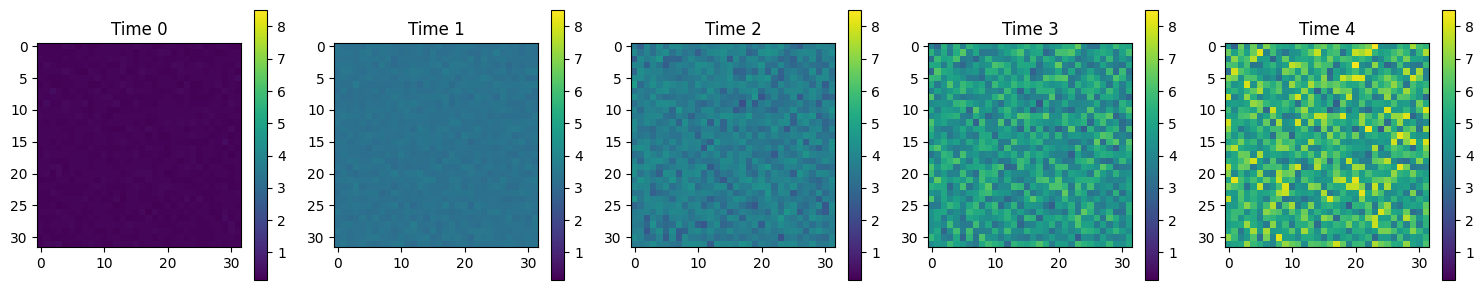

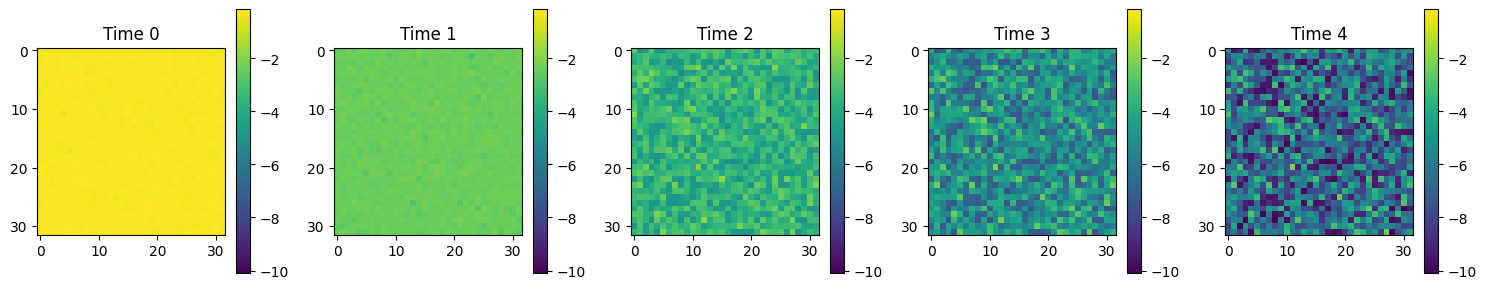

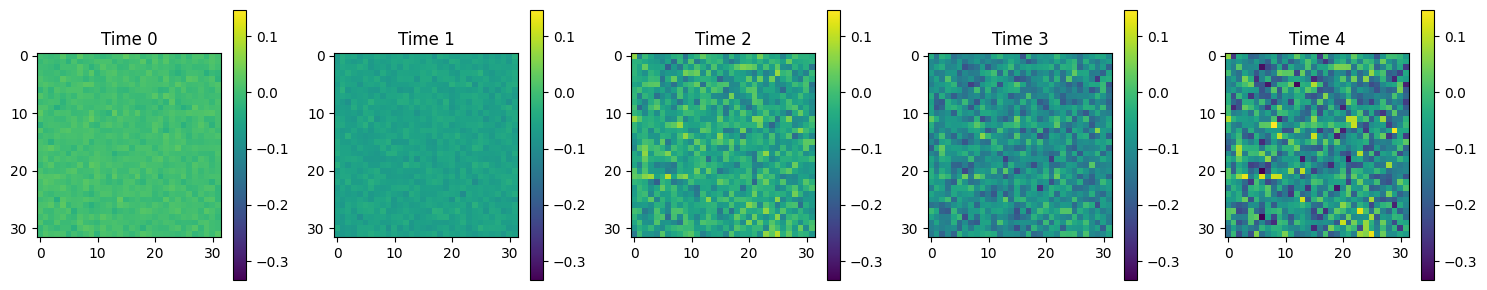

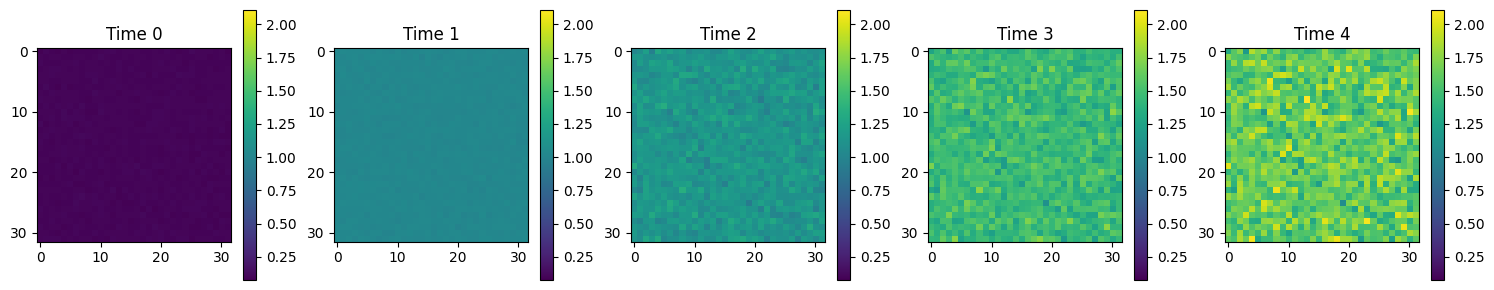

In [59]:
results = []
for _ in range(100):
    test = prior.sample(1, n_local_samples=N)
    results.append(test['data'][0])
    #visualize_simulation_output(test['data'][0])

#print(test['global_params'])
results = np.stack(results, axis=0)

visualize_simulation_output(np.max(results, axis=0))
visualize_simulation_output(np.min(results, axis=0))
visualize_simulation_output(np.mean(results, axis=0))
visualize_simulation_output(np.std(results, axis=0))

In [ ]:
np.random.seed(42)

global_posteriors = []
local_posteriors = []

true_global = []
true_local = []

start = time.time()
for i in range(100):
    print(i)
    sample = prior.sample(1, n_local_samples=N)
    true_global.append(sample['global_params'].flatten().cpu().numpy())
    true_local.append(sample['local_params'].flatten().cpu().numpy())
    sim_test = sample['data'][0].cpu().numpy()

    global_posterior, local_posterior = get_stan_posterior(sim_test, sigma_noise=prior.simulator.sigma_noise)
    global_posteriors.append(global_posterior)
    local_posteriors.append(local_posterior)
end = time.time()
print(end - start)

# make numpy arrays
global_posterior = np.stack(global_posteriors, axis=0)
local_posterior = np.stack(local_posteriors, axis=0).transpose(0, 2, 1)

true_global = np.stack(true_global, axis=0)
true_local = np.stack(true_local, axis=0)

DEBUG:cmdstanpy:cmd: /Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/ar1_grid info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpc3kowuso/s1xqlsc9.json
14:29:58 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:CmdStan args: ['/Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/ar1_grid', 'id=1', 'random', 'seed=16409', 'data', 'file=/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpc3kowuso/s1xqlsc9.json', 'output', 'file=/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpc3kowuso/ar1_gridv3ziqdx2/ar1_grid-20250428142958_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
14:29:58 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_t

0


14:30:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [3] done processing
INFO:cmdstanpy:Chain [3] done processing
14:30:29 - cmdstanpy - INFO - Chain [2] done processing
INFO:cmdstanpy:Chain [2] done processing
14:30:29 - cmdstanpy - INFO - Chain [4] done processing
INFO:cmdstanpy:Chain [4] done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/jonas.arruda/PyCharm Projects/hierarchical-abi/problems/ar1_grid', 'id=1', 'random', 'seed=16409', 'data', 'file=/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpc3kowuso/s1xqlsc9.json', 'output', 'file=/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/tmpc3kowuso/ar1_gridv3ziqdx2/ar1_grid-20250428142958_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/t

1


In [ ]:
#np.save(f'problems/ar1/global_posterior_{N}.npy', global_posterior)
#np.save(f'problems/ar1/local_posterior_{N}.npy', local_posterior)
#np.save(f'problems/ar1/true_global_{N}.npy', true_global)
#np.save(f'problems/ar1/true_local_{N}.npy', true_local)

In [ ]:
# timing (10 datasets)
# 4x4: 2.03s / 10 = 0.20s
# 8x8: 8.89s / 10 = 0.89s
# 16x16: 52.52s / 10 = 5.25s
# 32x32: 3600s / 100 = 36s

data_n = [4*4, 8*8, 16*16, 32*32]
time_n = np.array([0.2, 0.89, 5.25, 36]) / 60.

plt.plot(data_n, time_n)
plt.xlabel('Number of data points')
plt.ylabel('Execution time (min)')
plt.yscale('log')
plt.xscale('log')
#plt.xticks(data_n)
plt.show()

In [ ]:
#global_posterior = np.load(f'problems/ar1/global_posterior_{N}.npy')
#local_posterior = np.load(f'problems/ar1/local_posterior_{N}.npy')
#true_global = np.load(f'problems/ar1/true_global_{N}.npy')
#true_local = np.load(f'problems/ar1/true_local_{N}.npy')

# Plotting

In [ ]:
fig = diagnostics.recovery(global_posterior, true_global, variable_names=global_param_names)
#fig.savefig(f'plots/recovery_global_STAN_n_grid{N}.png')

fig = diagnostics.calibration_ecdf(global_posterior, true_global, difference=True, variable_names=global_param_names)
#fig.savefig(f'plots/ecdf_global_STAN_n_grid{N}.png')

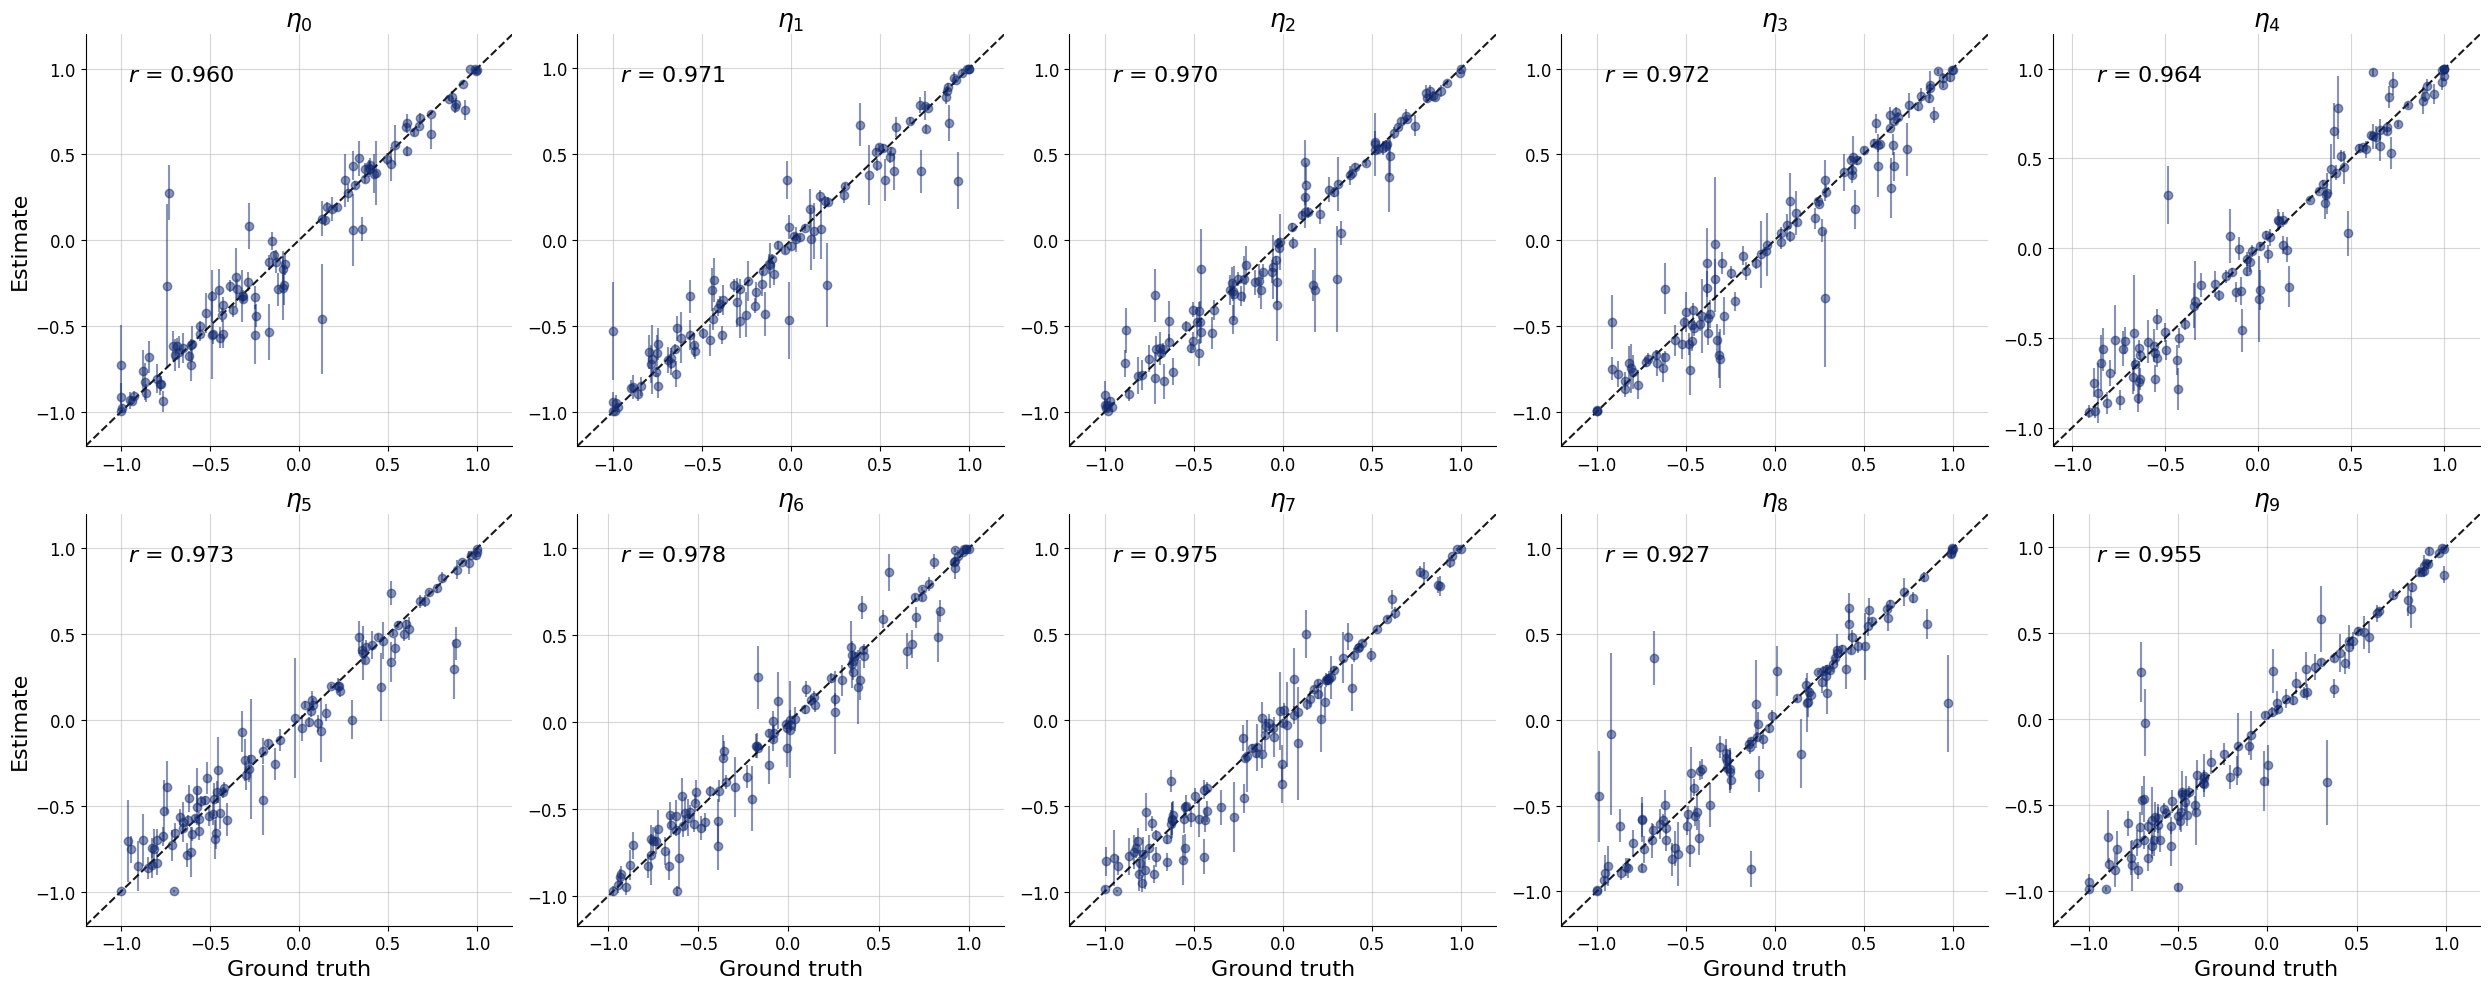

In [44]:
diagnostics.recovery(local_posterior[:, :, :10], true_local[:, :10], variable_names=local_param_names[:10]);

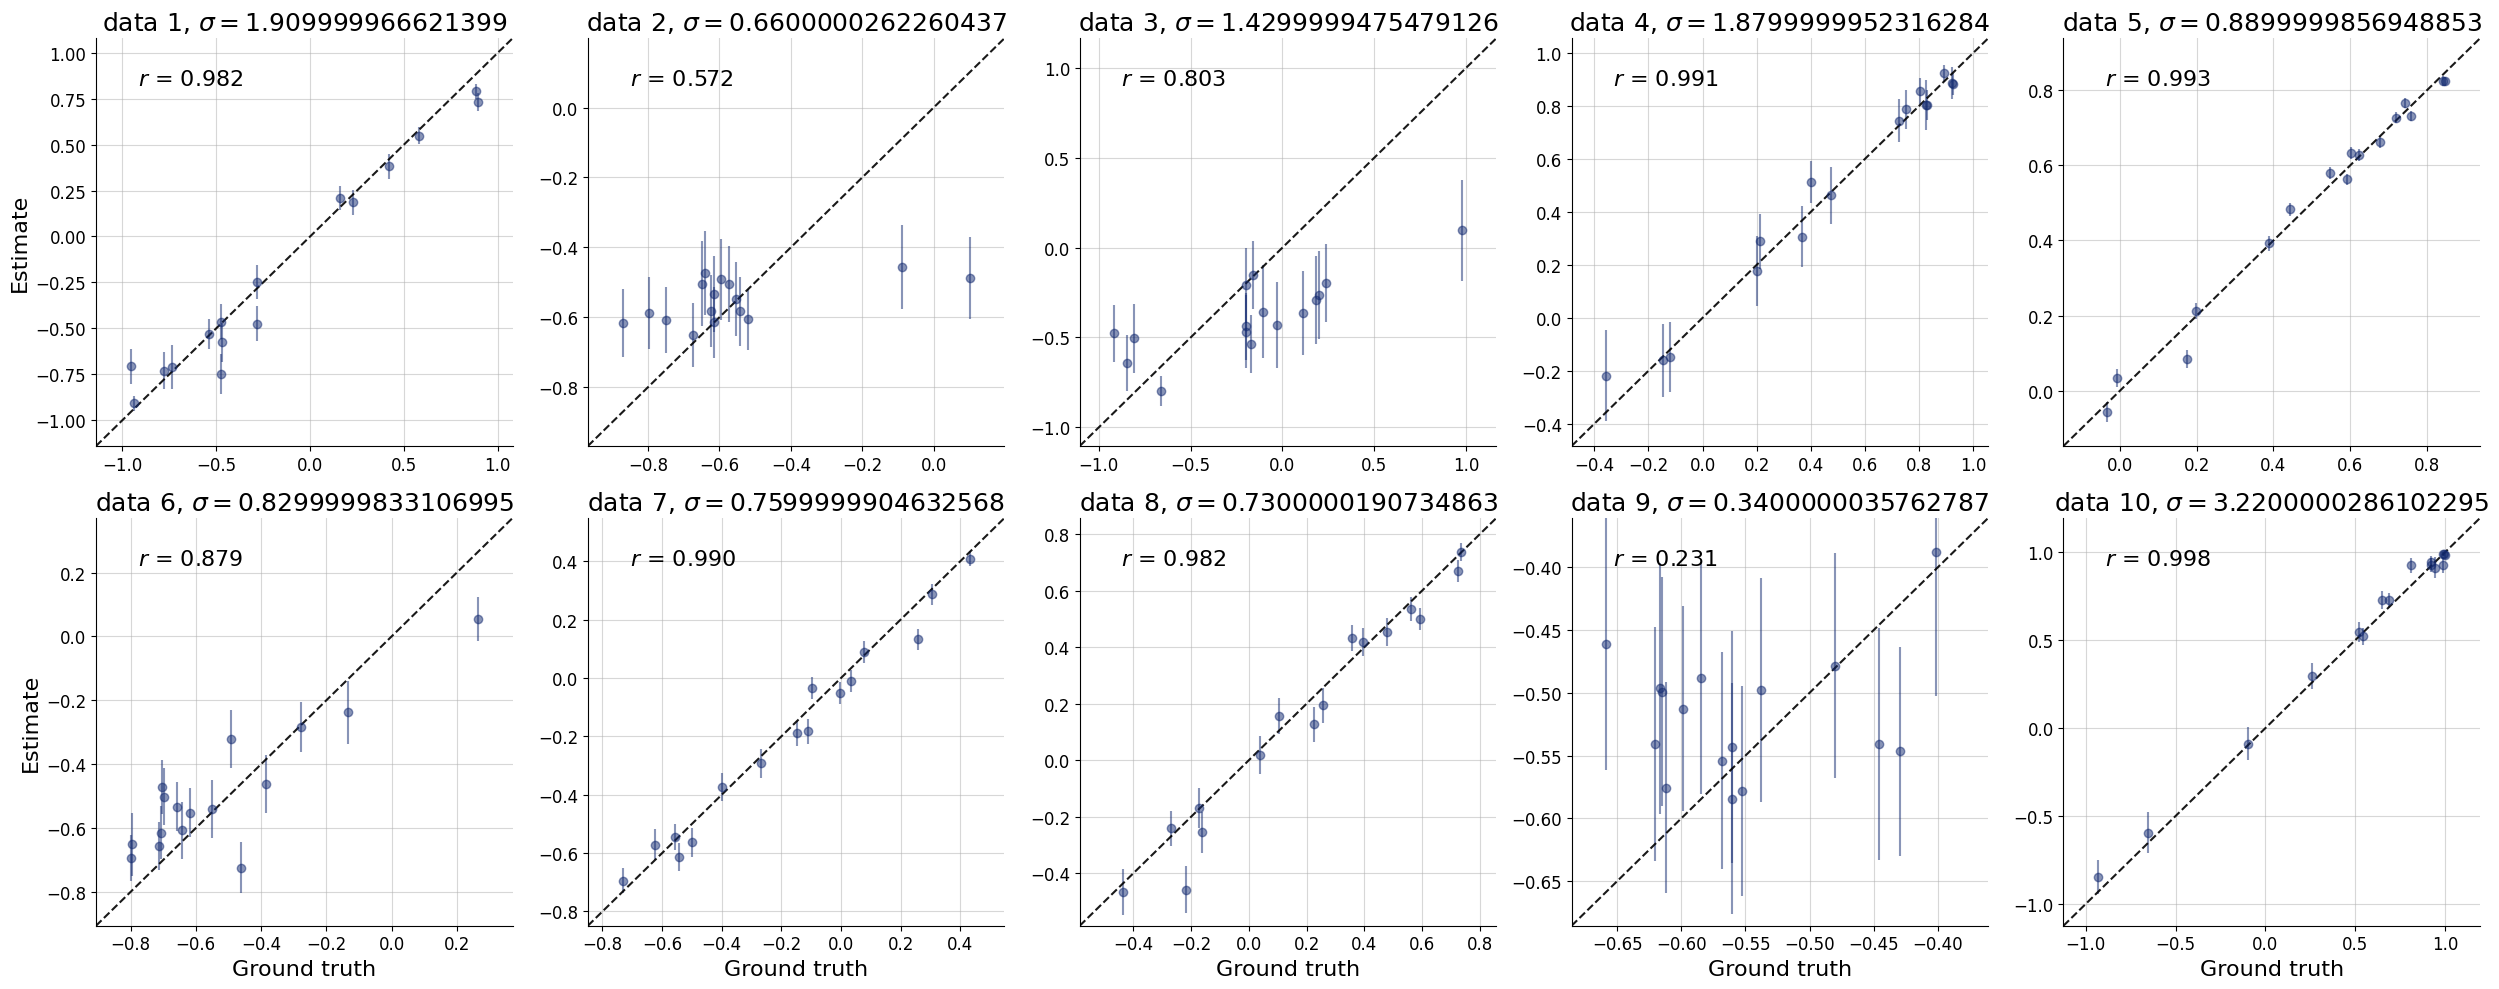

In [57]:
# here we can see shrinkage
diagnostics.recovery(local_posterior.transpose(2, 1, 0)[:, :, :10], true_local.transpose(1, 0)[:, :10],
            variable_names=[f'data {i+1}, $\sigma={np.round(np.exp(true_global[i, 2]), 2)}$' for i in range(10)]);

In [ ]:
local_posterior_raw = prior.back_transform_local_params(local_posterior)

plot_shrinkage(global_posterior[:12, :, 1:], local_posterior_raw[:12, :, :, np.newaxis], min_max=(-5, 5))